In [87]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [132]:
import requests
from time import sleep
import json
import wgetter
import os
import re

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# Fake image finder
Training a convolutional neural network to recognize photoshoped images by using images from [reddit.com/r/photoshopbattles](https://reddit.com/r/photoshopbattles)

# Download training images
### Get real images (from the original image that people will be competing with)

In [23]:
top_url = 'https://www.reddit.com/r/photoshopbattles/top.json?sort=top&t=all&limit=100'
headers={"User-agent" : "reddit_photoshopbattles_fetches by /u/openedarc"} # otherwise
after = None
posts = []
for _ in range(3):
    curr_url = top_url
    if after:
        curr_url += f'&after={after}'
    data = requests.get(curr_url, headers=headers).json()['data']
    after = data['after']
    posts.extend(data['children'])
    sleep(5)

real_urls = [p['data']['url'] for p in posts]

In [ ]:
for url in real_urls:
    try: wgetter.download(url, outdir=os.path.expanduser('~/data/photoshop/train/real'))
    except: print('error')

### Get fake image urls (the top comment)
We only use one fake image per real image so we don't train to much on fake images.

In [ ]:
bodies = []
comments_urls = ['https://reddit.com' + p['data']['permalink'] + '.json' for p in posts]
for c_url in comments_urls:
    comments = requests.get(c_url, headers=headers).json()[1]['data']['children']
    bodies.append([c['data']['body'] for c in comments if 'body' in c['data']])
    sleep(2)

In [119]:
fake_urls = []

# regexes for extracting images from comments
notdirect = r"((?:https?://imgur\.com)(?:\/[b-zA-Z0-9][a-zA-Z0-9]+))"
direct = r"((?:https?://i\.imgur\.com)(?:\/[b-zA-Z0-9][a-zA-Z0-9]+)(?:\.jpe?g|\.png))"

for body in bodies:
    direct_url = re.search(direct, body[0])
    if direct_url:
        fake_urls.append(direct_url.group())
        continue
    notdirect_url = re.search(notdirect, body[0])
    if notdirect_url:
        fake_urls.append(notdirect_url.group() + '.png')

In [ ]:
for url in real_urls:
    try: wgetter.download(url, outdir=os.path.expanduser('~/data/photoshop/train/fake'))
    except: print('error')

# Create a validation set
Randomly selects about a third and moves them to a validation folder

Probably we should test to see if it works better having pairs of images in the same set (e.g. real and fake in training) or whether it's better to split them. I think it would be better to split them

From http://www.fast.ai/2017/11/13/validation-sets/:
> If you put one of the above images in your training set and one in the validation set, your model will seem to be performing better than it would on new people. Another perspective is that if you used all the people in training your model, your model may be overfitting to particularities of those specific people, and not just learning the states (texting, eating, etc).

So we should further experiment

In [ ]:
!cd ~/data/photoshop/real
!ls | shuf -n 85 | xargs mv -t ../valid/real/
!cd ~/data/photoshop/fake
!ls | shuf -n 85 | xargs mv -t ../valid/fake/

# Do the learning
Using resnet34 pretrainged on image net

learning rate is 0.001 and 4 epochs

In [135]:
arch=resnet34
data = ImageClassifierData.from_paths("data/photoshop/", bs=10, tfms=tfms_from_model(arch, 700))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.001, 4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[0.      0.89391 0.62198 0.65111]                          
[1.      0.77857 0.57455 0.70222]                           
[2.      0.70002 0.5696  0.72667]                           
[3.      0.64295 0.52528 0.77333]                         



In [138]:
preds = np.argmax(learn.predict(), axis=1) # from log probabilities to 0 or 1 (returns the index of maximum value)
probs = np.exp(learn.predict()[:,1])

# Look at the results
## A few that were classified correctly
probability of 0 is fake, 1 is real

We can only get an accuracy of 77.3% with this training method

valid/fake/hchflMn.png
0.3593593


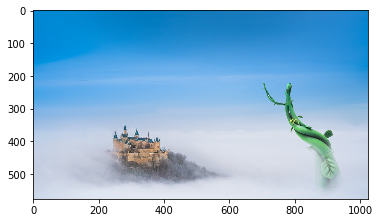

In [166]:
def show_example(index, is_correct=True):
    matches = np.where((preds == data.val_y) == is_correct)[0]
    plt.imshow(plt.imread(f'data/photoshop/{data.val_ds.fnames[matches[index]]}'))
    print(data.val_ds.fnames[matches[index]])
    print(probs[matches[index]])
    
show_example(0, is_correct=True)

valid/real/cC9MEEc.jpg
0.7066212


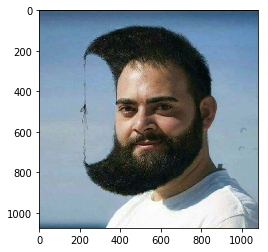

In [167]:
show_example(80, is_correct=True)

## A few that were classified incorrectly

valid/fake/c69wRMP.jpg
0.8182157


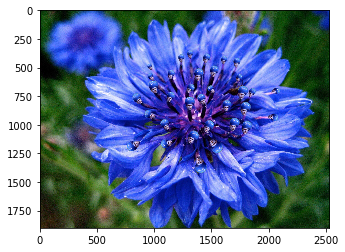

In [168]:
show_example(2, is_correct=False)

valid/real/FEsCWWT.jpg
0.18979369


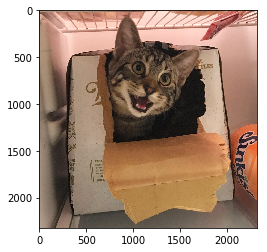

In [169]:
show_example(30, is_correct=False)